# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [48]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

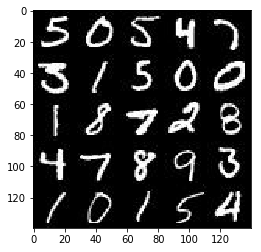

In [49]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

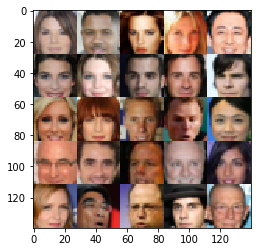

In [50]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [51]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [52]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [53]:
def c2d_layer(inputs, filters, kernel_size, strides, padding, training, alpha, applyleakyrelu=True):
    
    layer = tf.layers.conv2d(inputs=inputs, filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)
    layer = tf.layers.batch_normalization(layer, training=training)
    if(applyleakyrelu):
        layer = tf.maximum(alpha * layer, layer)
    
    return layer

In [54]:
def discriminator(images, reuse=False, n_units=128, alpha=0.01, training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):

        #def c2d_layer(inputs, filters, kernel_size, strides, padding, training, alpha, applyleakyrelu=True):
        # Input layer is 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = c2d_layer(relu1, 128, 5, 2, 'same', training, alpha)
        # 7 x 7 x 128
        
        x3 = c2d_layer(x2, 256, 5, 2, 'same', training, alpha)
        # 4 x 4 x 256
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [55]:
def c2dt_layer(inputs, filters, kernel_size, strides, padding, training, alpha, applyleakyrelu=True):
    
    layer = tf.layers.conv2d_transpose(inputs=inputs, filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)
    layer = tf.layers.batch_normalization(layer, training=training)
    if(applyleakyrelu):
        layer = tf.maximum(alpha * layer, layer)
    
    return layer

In [56]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # first fully conencted layer
        x0 = tf.layers.dense(z, 2 * 2 * 1024)
        
        # review comment: I suggest using layers with filters 1024, 512, 256, 128 as the layers 
        # for training your network. There is no need to use two layers each with 256 and 128 as
        # the number of filters.
        
        # reshape
        x0 = tf.reshape(x0, (-1, 2, 2, 1024))
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)
        # now 2 x 2 x 1024
        
        #def c2dt_layer(inputs, filters, kernel_size, strides, padding, training, applyleakyrelu=True):
        x1 = c2dt_layer(x0, 512, 4, 2, 'same', is_train, alpha, True)
        # now 4 x 4 x 512
        
        x2 = c2dt_layer(x1, 256, 4, 1, 'valid', is_train, alpha, True)
        # now 7 x 7 x 256
        
        x3 = c2dt_layer(x2, 128, 4, 2, 'same', is_train, alpha, True)
        # now 14 x 14 x 128

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')

        # now 28 x 28 x 3
        out = tf.tanh(logits)

        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [57]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
   
    #d_loss_real = tf.reduce_mean(
#        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [58]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [59]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [74]:
import numpy as np

def save_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, savepath):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.savefig(savepath, bbox_inches='tight')

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [96]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, num_images_show = 25, print_every = 100, show_every = 100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    import time, datetime

    sample_z = np.random.uniform(-1, 1, size=z_dim)
    
    samples, losses = [], []
    steps = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        start = time.time()
        print("Start: {}, LR {}, Beta {}".format(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start)), learning_rate, beta1))
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                # review comment: "You should increase batch size by a factor of two inside the inner for loop"
                batch_z = np.random.uniform(-1, 1, size=(2 * batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                # reviewer feedback: "Try running generator optimization one more time. It also helps in preventing discriminator loss from going to zero."
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step: {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    

                if steps % show_every == 0:
                    #def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
                   show_generator_output(sess, num_images_show, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, num_images_show, input_z, data_shape[3], data_image_mode) 
        done = time.time()
        elapsed = done - start
        print("Final discriminator loss: {:.4f}, final generator loss: {:.4f}".format(losses[-1][0], losses[-1][1]))
        save_generator_output(sess, num_images_show, input_z, data_shape[3], data_image_mode, os.path.join('./out/lr{}-beta{}-d{:.4f}-g{:.4f}.jpg'.format(learning_rate, beta1,losses[-1][0], losses[-1][1])))
        print("Done at {} - elapsed time: {}".format(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(done)), str(datetime.timedelta(seconds=elapsed))))

        
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Start: 2018-03-17 15:56:58, LR 0.001, Beta 0.05
Epoch 1/2... Step: 100... Discriminator Loss: 1.8808... Generator Loss: 0.2059
Final discriminator loss: 1.8807952404022217, final generator loss: 0.20587849617004395


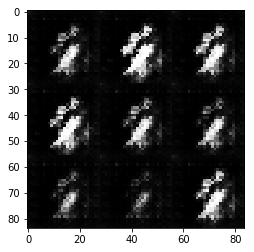

KeyboardInterrupt: 

In [95]:
batch_size = 50 #64
z_dim = 150 #150
learning_rate = 0.001 #0.002
beta1 = 0.05 # 0.05


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Start: 2018-03-17 13:49:24, LR 0.0002, Beta 0.2
Epoch 1/1... Step: 100... Discriminator Loss: 1.1871... Generator Loss: 0.8489


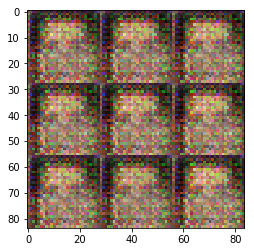

Epoch 1/1... Step: 200... Discriminator Loss: 0.5510... Generator Loss: 1.5595


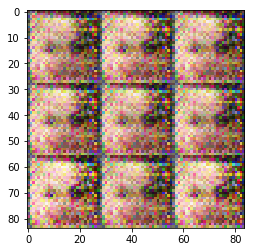

Epoch 1/1... Step: 300... Discriminator Loss: 1.5044... Generator Loss: 0.4942


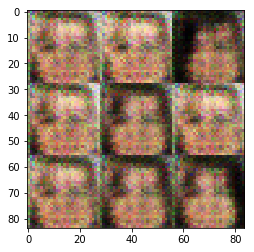

Epoch 1/1... Step: 400... Discriminator Loss: 1.4254... Generator Loss: 0.6880


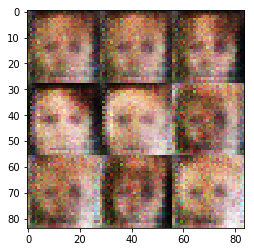

Epoch 1/1... Step: 500... Discriminator Loss: 1.4302... Generator Loss: 0.7230


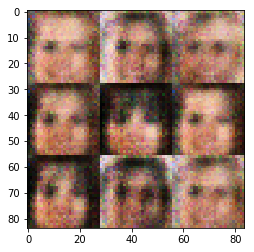

Epoch 1/1... Step: 600... Discriminator Loss: 1.4595... Generator Loss: 0.6681


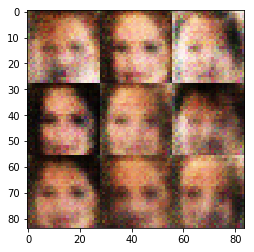

Epoch 1/1... Step: 700... Discriminator Loss: 1.5084... Generator Loss: 0.5469


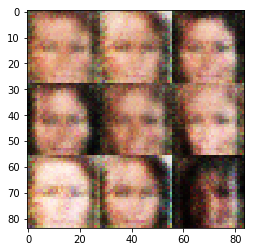

Epoch 1/1... Step: 800... Discriminator Loss: 1.4445... Generator Loss: 0.6515


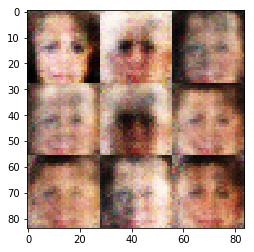

Epoch 1/1... Step: 900... Discriminator Loss: 1.4625... Generator Loss: 0.6125


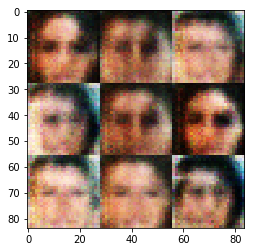

Epoch 1/1... Step: 1000... Discriminator Loss: 1.4614... Generator Loss: 0.6789


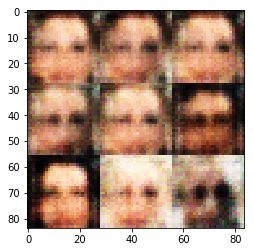

Epoch 1/1... Step: 1100... Discriminator Loss: 1.4769... Generator Loss: 0.5501


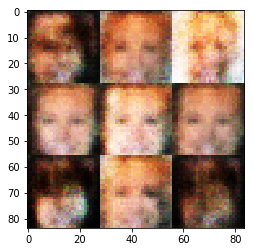

Epoch 1/1... Step: 1200... Discriminator Loss: 1.3560... Generator Loss: 0.7443


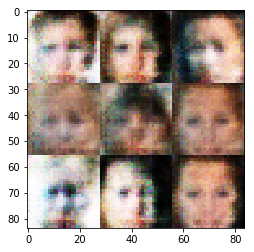

Epoch 1/1... Step: 1300... Discriminator Loss: 1.4204... Generator Loss: 0.5944


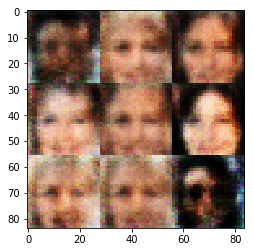

Epoch 1/1... Step: 1400... Discriminator Loss: 1.4408... Generator Loss: 0.6931


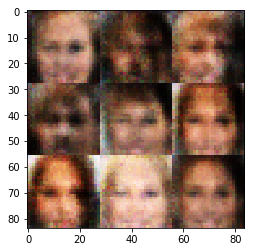

Epoch 1/1... Step: 1500... Discriminator Loss: 1.4709... Generator Loss: 0.5566


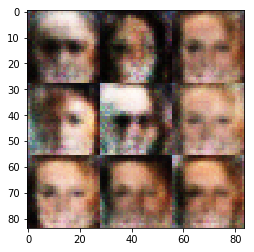

Epoch 1/1... Step: 1600... Discriminator Loss: 1.4402... Generator Loss: 0.6733


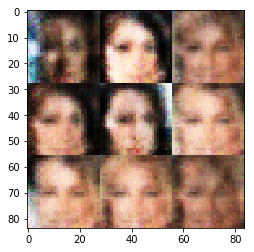

Epoch 1/1... Step: 1700... Discriminator Loss: 1.4580... Generator Loss: 0.6269


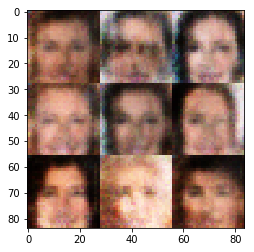

Epoch 1/1... Step: 1800... Discriminator Loss: 1.4561... Generator Loss: 0.7487


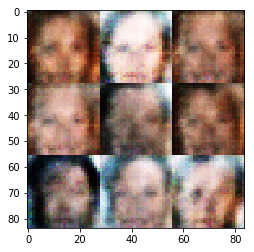

Epoch 1/1... Step: 1900... Discriminator Loss: 1.4649... Generator Loss: 0.5628


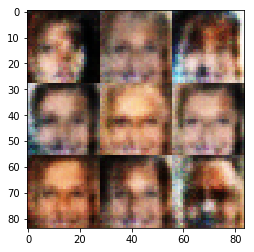

Epoch 1/1... Step: 2000... Discriminator Loss: 1.4368... Generator Loss: 0.7239


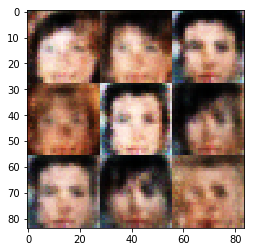

Epoch 1/1... Step: 2100... Discriminator Loss: 1.3961... Generator Loss: 0.5955


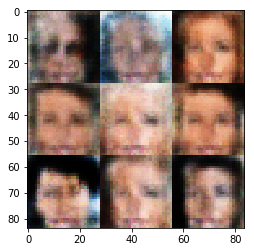

Epoch 1/1... Step: 2200... Discriminator Loss: 1.4216... Generator Loss: 0.6758


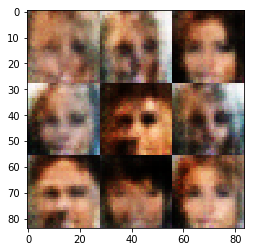

Epoch 1/1... Step: 2300... Discriminator Loss: 1.4517... Generator Loss: 0.6161


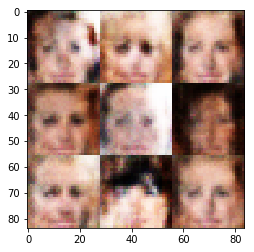

Epoch 1/1... Step: 2400... Discriminator Loss: 1.4489... Generator Loss: 0.6532


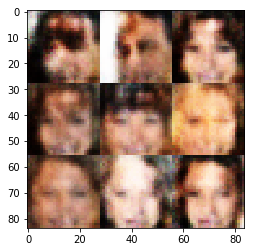

Epoch 1/1... Step: 2500... Discriminator Loss: 1.4006... Generator Loss: 0.7002


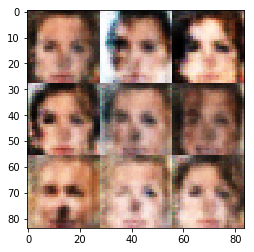

Epoch 1/1... Step: 2600... Discriminator Loss: 1.4087... Generator Loss: 0.7065


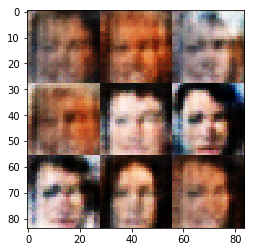

Epoch 1/1... Step: 2700... Discriminator Loss: 1.4051... Generator Loss: 0.8915


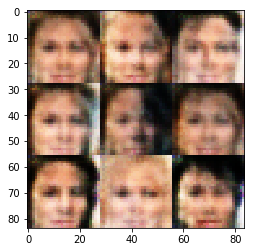

Epoch 1/1... Step: 2800... Discriminator Loss: 1.3955... Generator Loss: 0.7079


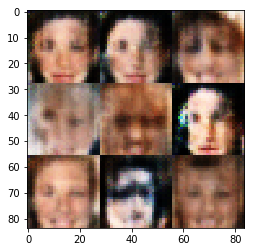

Epoch 1/1... Step: 2900... Discriminator Loss: 1.3765... Generator Loss: 0.6761


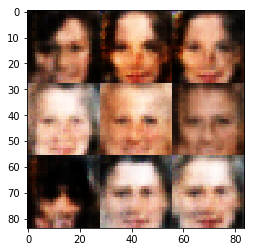

Epoch 1/1... Step: 3000... Discriminator Loss: 1.4677... Generator Loss: 0.6372


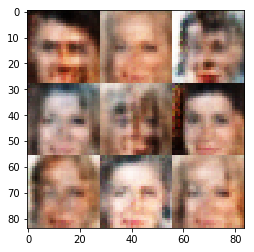

Epoch 1/1... Step: 3100... Discriminator Loss: 1.4308... Generator Loss: 0.5790


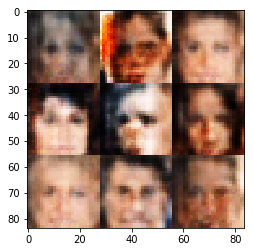

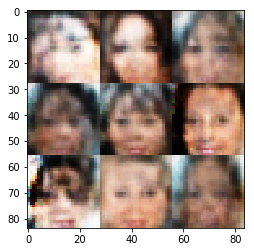

Done at 2018-03-17 14:14:39 - elapsed time: 0:25:14.967170
Start: 2018-03-17 14:14:43, LR 0.0002, Beta 0.5
Epoch 1/1... Step: 100... Discriminator Loss: 0.8821... Generator Loss: 1.1698


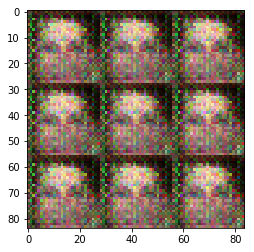

Epoch 1/1... Step: 200... Discriminator Loss: 0.3596... Generator Loss: 1.9944


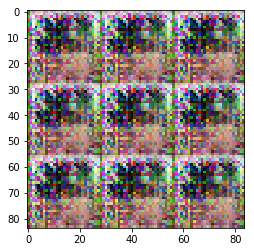

Epoch 1/1... Step: 300... Discriminator Loss: 1.7943... Generator Loss: 0.4811


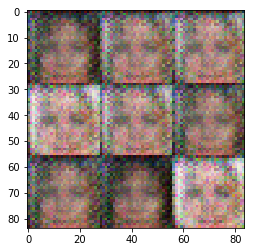

Epoch 1/1... Step: 400... Discriminator Loss: 1.6405... Generator Loss: 0.7641


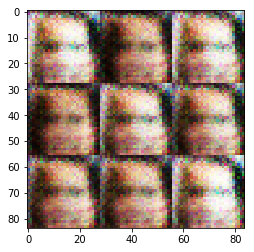

Epoch 1/1... Step: 500... Discriminator Loss: 1.0262... Generator Loss: 1.0203


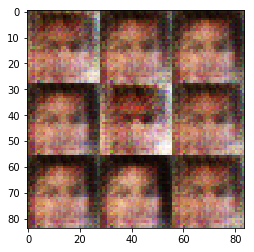

Epoch 1/1... Step: 600... Discriminator Loss: 1.4720... Generator Loss: 0.6436


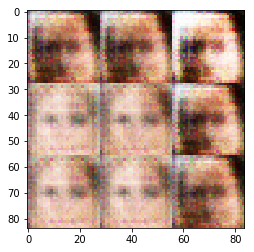

Epoch 1/1... Step: 700... Discriminator Loss: 1.4908... Generator Loss: 0.6228


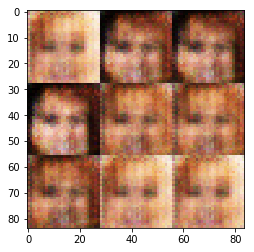

Epoch 1/1... Step: 800... Discriminator Loss: 1.4689... Generator Loss: 0.6937


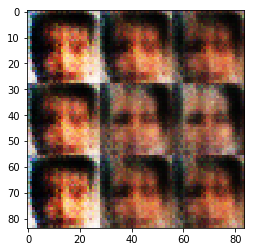

Epoch 1/1... Step: 900... Discriminator Loss: 1.5483... Generator Loss: 0.6022


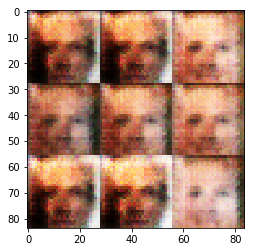

Epoch 1/1... Step: 1000... Discriminator Loss: 1.3967... Generator Loss: 0.6577


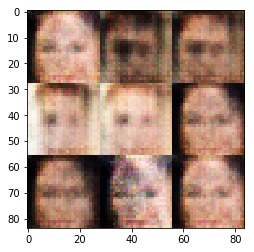

Epoch 1/1... Step: 1100... Discriminator Loss: 1.4723... Generator Loss: 0.6448


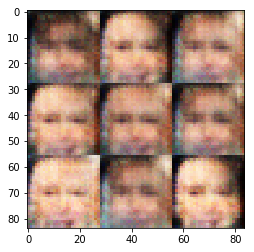

Epoch 1/1... Step: 1200... Discriminator Loss: 1.4428... Generator Loss: 0.6841


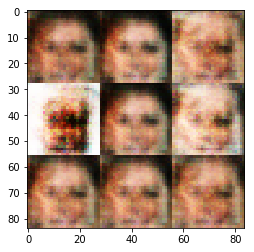

Epoch 1/1... Step: 1300... Discriminator Loss: 1.5334... Generator Loss: 0.6118


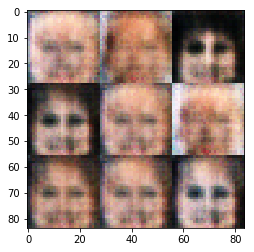

Epoch 1/1... Step: 1400... Discriminator Loss: 1.5003... Generator Loss: 0.5670


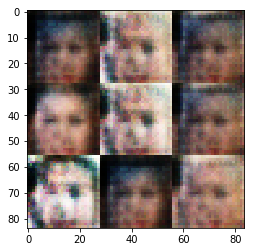

Epoch 1/1... Step: 1500... Discriminator Loss: 1.5362... Generator Loss: 0.6296


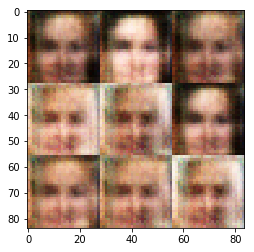

Epoch 1/1... Step: 1600... Discriminator Loss: 1.3302... Generator Loss: 0.7615


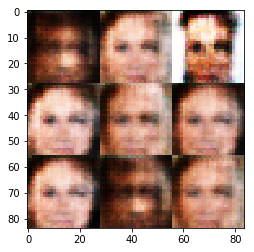

Epoch 1/1... Step: 1700... Discriminator Loss: 1.4448... Generator Loss: 0.6298


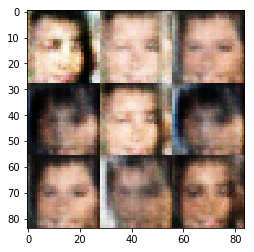

Epoch 1/1... Step: 1800... Discriminator Loss: 1.4757... Generator Loss: 0.6314


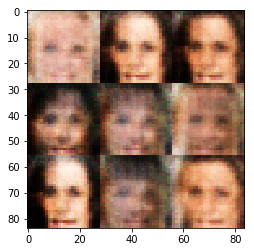

Epoch 1/1... Step: 1900... Discriminator Loss: 1.4371... Generator Loss: 0.6435


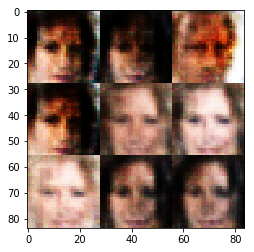

Epoch 1/1... Step: 2000... Discriminator Loss: 1.4407... Generator Loss: 0.6850


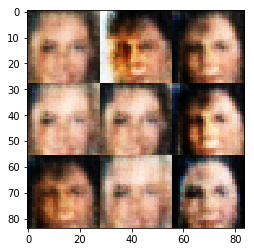

Epoch 1/1... Step: 2100... Discriminator Loss: 1.4237... Generator Loss: 0.6380


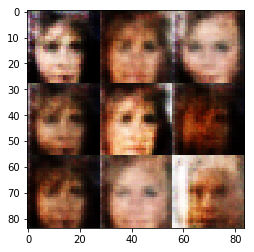

Epoch 1/1... Step: 2200... Discriminator Loss: 1.4655... Generator Loss: 0.6552


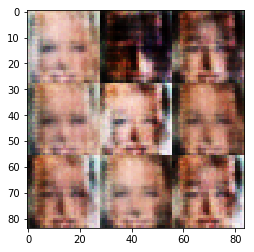

Epoch 1/1... Step: 2300... Discriminator Loss: 1.4775... Generator Loss: 0.6133


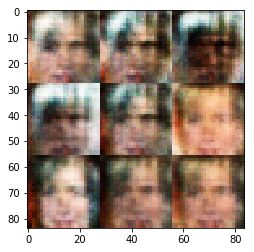

Epoch 1/1... Step: 2400... Discriminator Loss: 1.4256... Generator Loss: 0.6853


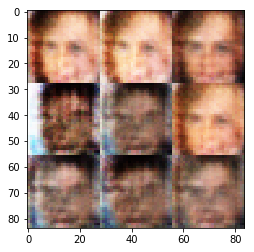

Epoch 1/1... Step: 2500... Discriminator Loss: 1.4407... Generator Loss: 0.6160


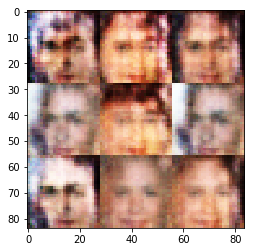

Epoch 1/1... Step: 2600... Discriminator Loss: 1.4551... Generator Loss: 0.6095


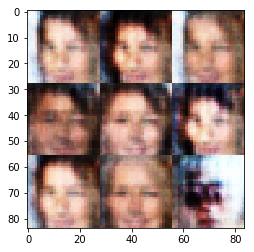

Epoch 1/1... Step: 2700... Discriminator Loss: 1.4116... Generator Loss: 0.6923


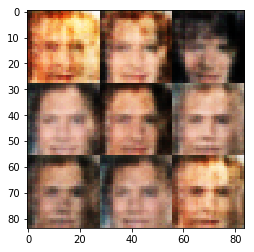

Epoch 1/1... Step: 2800... Discriminator Loss: 1.4792... Generator Loss: 0.6320


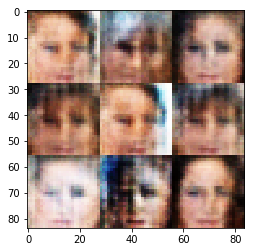

Epoch 1/1... Step: 2900... Discriminator Loss: 1.4223... Generator Loss: 0.6360


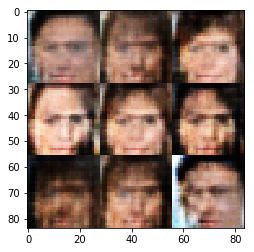

Epoch 1/1... Step: 3000... Discriminator Loss: 1.4265... Generator Loss: 0.6814


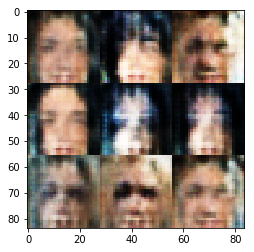

Epoch 1/1... Step: 3100... Discriminator Loss: 1.3879... Generator Loss: 0.6739


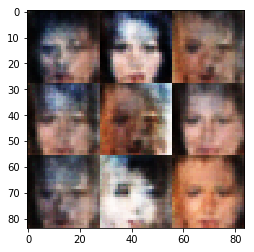

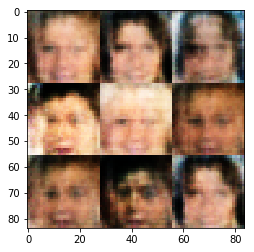

Done at 2018-03-17 14:39:55 - elapsed time: 0:25:12.380476
Start: 2018-03-17 14:39:59, LR 0.0008, Beta 0.2
Epoch 1/1... Step: 100... Discriminator Loss: 1.5757... Generator Loss: 0.8659


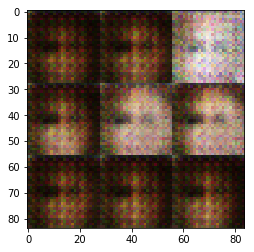

Epoch 1/1... Step: 200... Discriminator Loss: 1.7366... Generator Loss: 0.5753


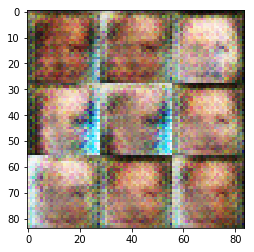

Epoch 1/1... Step: 300... Discriminator Loss: 1.4937... Generator Loss: 0.6925


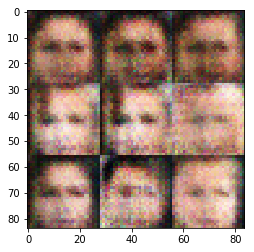

Epoch 1/1... Step: 400... Discriminator Loss: 1.4994... Generator Loss: 0.7757


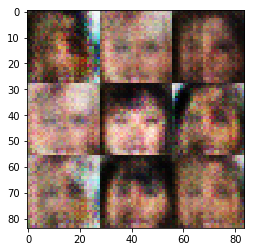

Epoch 1/1... Step: 500... Discriminator Loss: 1.5579... Generator Loss: 0.4410


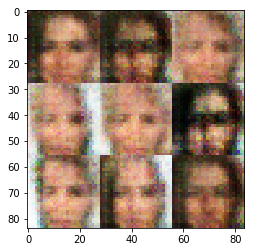

Epoch 1/1... Step: 600... Discriminator Loss: 1.5133... Generator Loss: 0.6378


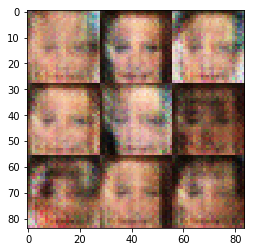

Epoch 1/1... Step: 700... Discriminator Loss: 1.6079... Generator Loss: 0.8378


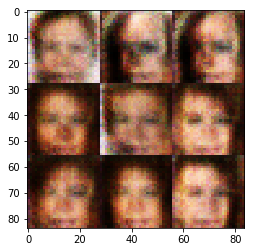

Epoch 1/1... Step: 800... Discriminator Loss: 1.4152... Generator Loss: 0.6914


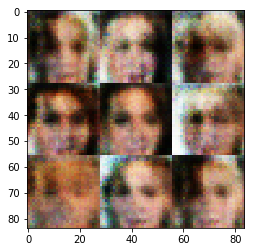

Epoch 1/1... Step: 900... Discriminator Loss: 1.3887... Generator Loss: 0.6822


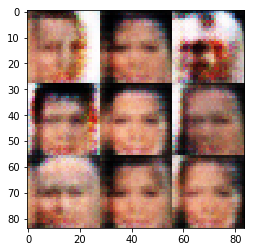

Epoch 1/1... Step: 1000... Discriminator Loss: 1.4464... Generator Loss: 0.9313


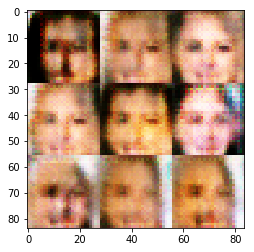

Epoch 1/1... Step: 1100... Discriminator Loss: 1.3854... Generator Loss: 0.6202


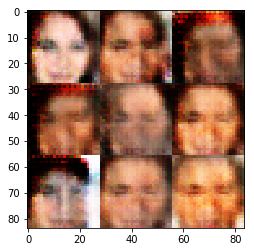

Epoch 1/1... Step: 1200... Discriminator Loss: 1.4259... Generator Loss: 1.0409


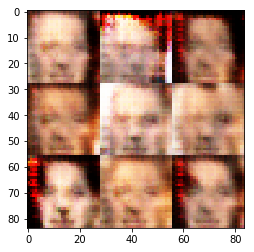

Epoch 1/1... Step: 1300... Discriminator Loss: 1.4167... Generator Loss: 0.5561


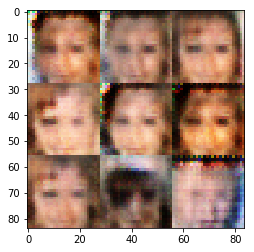

Epoch 1/1... Step: 1400... Discriminator Loss: 1.4513... Generator Loss: 0.5603


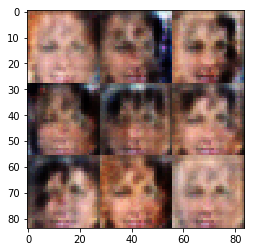

Epoch 1/1... Step: 1500... Discriminator Loss: 1.3796... Generator Loss: 0.6751


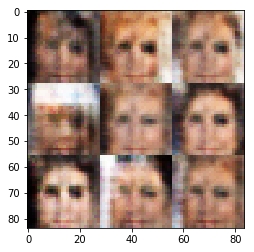

Epoch 1/1... Step: 1600... Discriminator Loss: 1.4044... Generator Loss: 0.7301


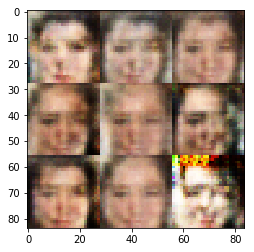

Epoch 1/1... Step: 1700... Discriminator Loss: 1.3487... Generator Loss: 0.6799


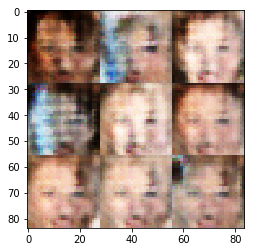

Epoch 1/1... Step: 1800... Discriminator Loss: 1.3836... Generator Loss: 0.6104


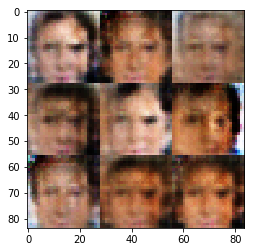

Epoch 1/1... Step: 1900... Discriminator Loss: 0.8085... Generator Loss: 0.6363


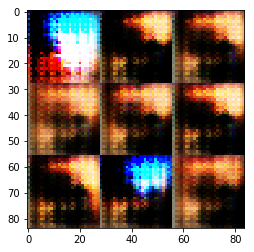

Epoch 1/1... Step: 2000... Discriminator Loss: 1.2164... Generator Loss: 0.7326


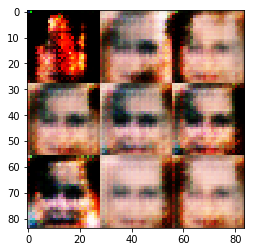

Epoch 1/1... Step: 2100... Discriminator Loss: 1.5307... Generator Loss: 0.6917


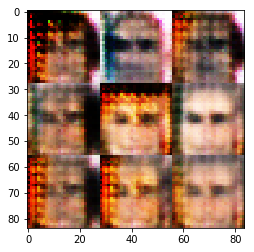

Epoch 1/1... Step: 2200... Discriminator Loss: 1.5177... Generator Loss: 0.3059


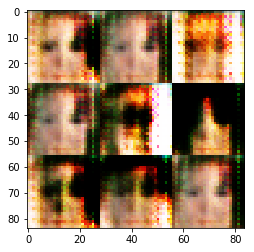

Epoch 1/1... Step: 2300... Discriminator Loss: 1.2332... Generator Loss: 0.5341


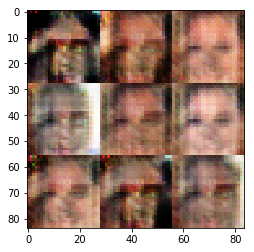

Epoch 1/1... Step: 2400... Discriminator Loss: 1.3838... Generator Loss: 0.8785


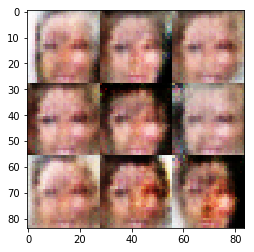

Epoch 1/1... Step: 2500... Discriminator Loss: 1.4289... Generator Loss: 0.6909


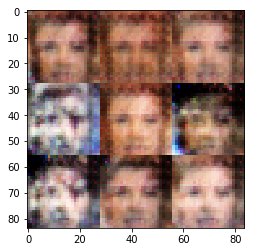

Epoch 1/1... Step: 2600... Discriminator Loss: 1.3363... Generator Loss: 0.8627


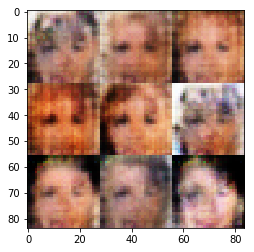

Epoch 1/1... Step: 2700... Discriminator Loss: 1.4636... Generator Loss: 0.9450


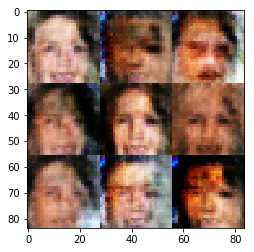

Epoch 1/1... Step: 2800... Discriminator Loss: 1.3331... Generator Loss: 0.5995


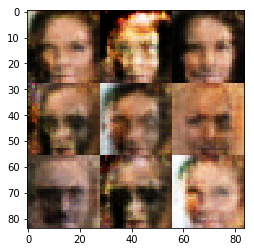

Epoch 1/1... Step: 2900... Discriminator Loss: 1.4727... Generator Loss: 0.5414


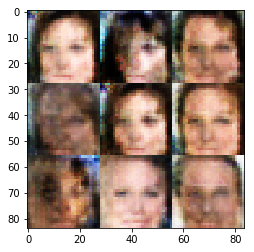

Epoch 1/1... Step: 3000... Discriminator Loss: 1.3825... Generator Loss: 0.7626


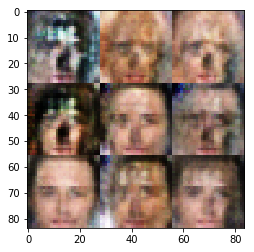

Epoch 1/1... Step: 3100... Discriminator Loss: 1.3482... Generator Loss: 0.6631


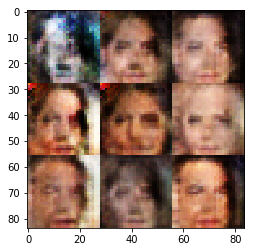

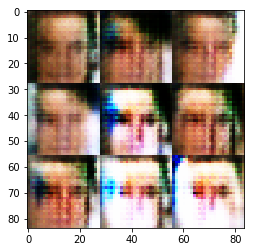

Done at 2018-03-17 15:05:11 - elapsed time: 0:25:11.882662
Start: 2018-03-17 15:05:15, LR 0.0008, Beta 0.5
Epoch 1/1... Step: 100... Discriminator Loss: 1.8064... Generator Loss: 0.4436


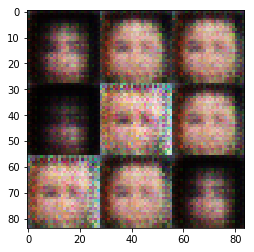

Epoch 1/1... Step: 200... Discriminator Loss: 1.4798... Generator Loss: 0.6409


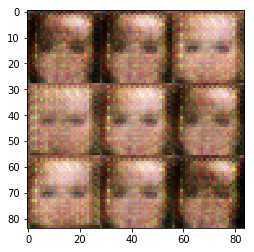

Epoch 1/1... Step: 300... Discriminator Loss: 1.4262... Generator Loss: 0.5718


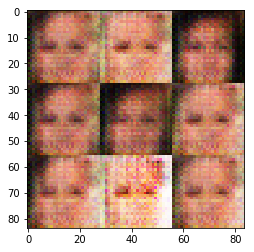

Epoch 1/1... Step: 400... Discriminator Loss: 1.4861... Generator Loss: 0.8171


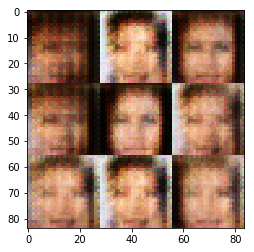

Epoch 1/1... Step: 500... Discriminator Loss: 1.4353... Generator Loss: 0.8860


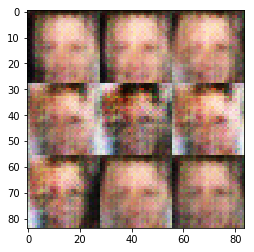

Epoch 1/1... Step: 600... Discriminator Loss: 1.2932... Generator Loss: 0.8221


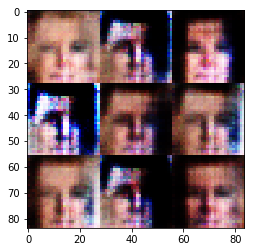

Epoch 1/1... Step: 700... Discriminator Loss: 1.6663... Generator Loss: 0.6463


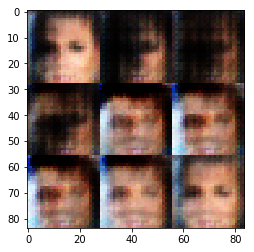

Epoch 1/1... Step: 800... Discriminator Loss: 1.4367... Generator Loss: 0.7449


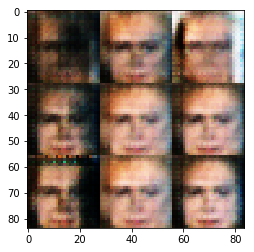

Epoch 1/1... Step: 900... Discriminator Loss: 1.4690... Generator Loss: 0.5442


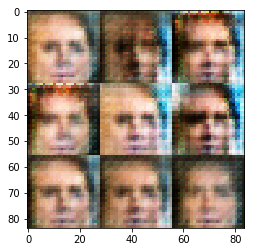

Epoch 1/1... Step: 1000... Discriminator Loss: 1.4916... Generator Loss: 0.6297


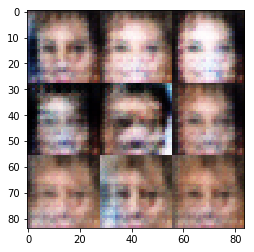

Epoch 1/1... Step: 1100... Discriminator Loss: 1.6030... Generator Loss: 0.3771


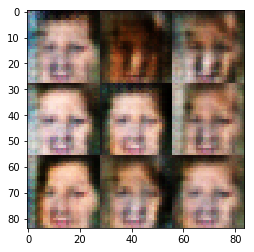

Epoch 1/1... Step: 1200... Discriminator Loss: 1.4803... Generator Loss: 0.7605


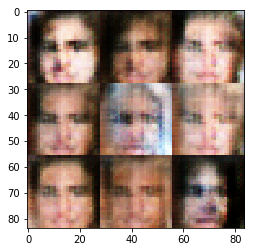

Epoch 1/1... Step: 1300... Discriminator Loss: 1.5390... Generator Loss: 0.7311


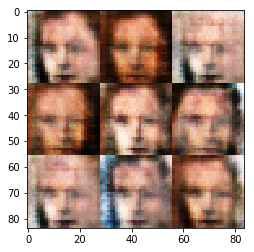

Epoch 1/1... Step: 1400... Discriminator Loss: 1.4321... Generator Loss: 0.7667


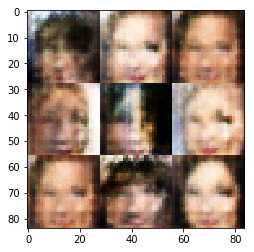

Epoch 1/1... Step: 1500... Discriminator Loss: 1.3845... Generator Loss: 0.8394


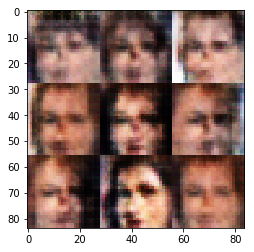

Epoch 1/1... Step: 1600... Discriminator Loss: 1.3949... Generator Loss: 0.6095


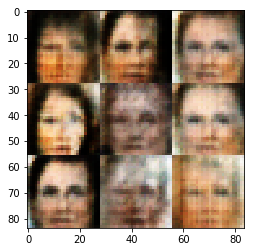

Epoch 1/1... Step: 1700... Discriminator Loss: 1.4252... Generator Loss: 0.7485


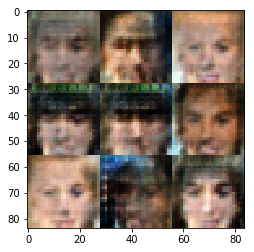

Epoch 1/1... Step: 1800... Discriminator Loss: 1.3908... Generator Loss: 0.8895


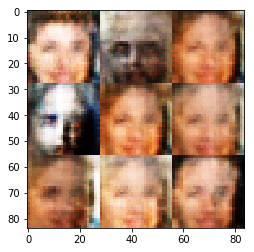

Epoch 1/1... Step: 1900... Discriminator Loss: 1.4024... Generator Loss: 0.5542


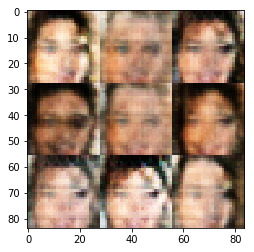

Epoch 1/1... Step: 2000... Discriminator Loss: 1.3780... Generator Loss: 0.6739


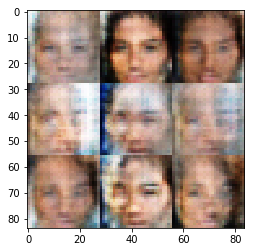

Epoch 1/1... Step: 2100... Discriminator Loss: 1.4448... Generator Loss: 0.6809


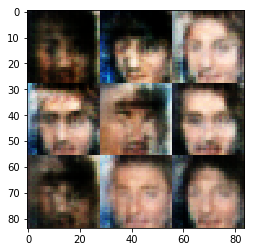

Epoch 1/1... Step: 2200... Discriminator Loss: 1.5376... Generator Loss: 0.8755


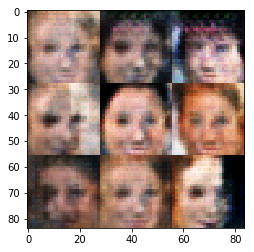

Epoch 1/1... Step: 2300... Discriminator Loss: 1.3883... Generator Loss: 0.7259


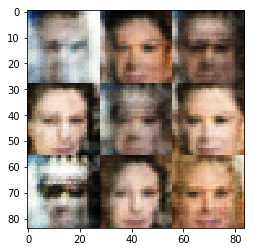

Epoch 1/1... Step: 2400... Discriminator Loss: 1.4369... Generator Loss: 0.7305


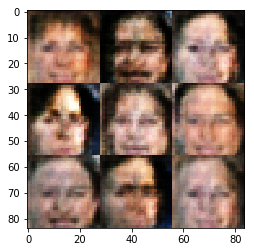

Epoch 1/1... Step: 2500... Discriminator Loss: 1.4182... Generator Loss: 0.8220


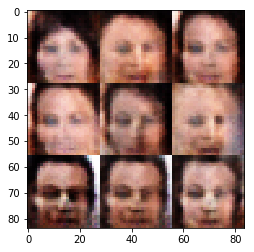

Epoch 1/1... Step: 2600... Discriminator Loss: 1.4228... Generator Loss: 0.5539


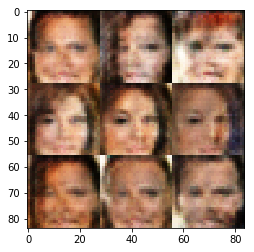

Epoch 1/1... Step: 2700... Discriminator Loss: 1.3729... Generator Loss: 0.7283


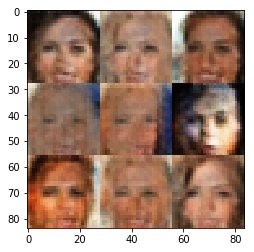

Epoch 1/1... Step: 2800... Discriminator Loss: 1.4100... Generator Loss: 0.6176


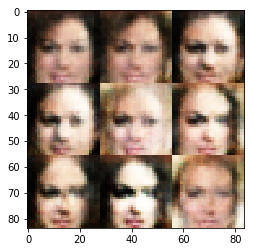

Epoch 1/1... Step: 2900... Discriminator Loss: 1.4111... Generator Loss: 0.7036


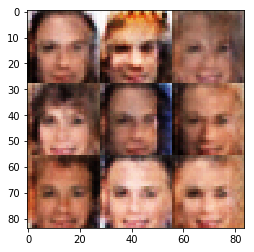

Epoch 1/1... Step: 3000... Discriminator Loss: 1.4423... Generator Loss: 0.6582


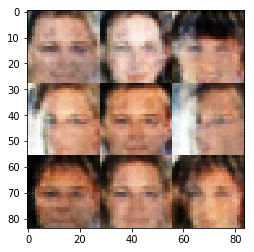

Epoch 1/1... Step: 3100... Discriminator Loss: 1.3881... Generator Loss: 0.6893


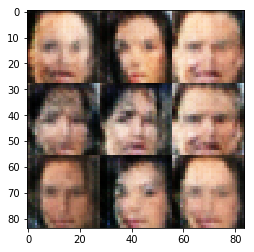

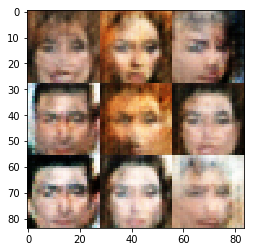

Done at 2018-03-17 15:30:27 - elapsed time: 0:25:12.575077


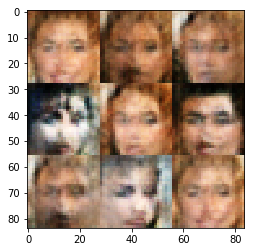

In [87]:
# trying out multiple values...


batch_size = 64
z_dim = 100
learning_rate =  0.0002, 0.0008
beta1 = .2, 0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
for lr in learning_rate:
    for b in beta1:
        with tf.Graph().as_default():
            train(epochs, batch_size, z_dim, lr, b, celeba_dataset.get_batches,
                  celeba_dataset.shape, celeba_dataset.image_mode)

Start: 2018-03-17 13:18:45
Epoch 1/1... Step: 10... Discriminator Loss: 3.1516... Generator Loss: 0.1195
Epoch 1/1... Step: 20... Discriminator Loss: 3.6042... Generator Loss: 0.0724
Epoch 1/1... Step: 30... Discriminator Loss: 3.6799... Generator Loss: 0.0501
Epoch 1/1... Step: 40... Discriminator Loss: 3.2791... Generator Loss: 0.1598
Epoch 1/1... Step: 50... Discriminator Loss: 2.9698... Generator Loss: 0.0760
Epoch 1/1... Step: 60... Discriminator Loss: 1.5970... Generator Loss: 0.3780
Epoch 1/1... Step: 70... Discriminator Loss: 1.0162... Generator Loss: 0.7496
Epoch 1/1... Step: 80... Discriminator Loss: 1.8202... Generator Loss: 0.2676
Epoch 1/1... Step: 90... Discriminator Loss: 0.9884... Generator Loss: 0.8065
Epoch 1/1... Step: 100... Discriminator Loss: 0.7023... Generator Loss: 1.5428


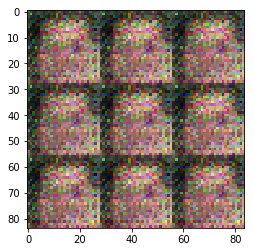

Epoch 1/1... Step: 110... Discriminator Loss: 0.5688... Generator Loss: 1.4051
Epoch 1/1... Step: 120... Discriminator Loss: 0.5986... Generator Loss: 2.6408
Epoch 1/1... Step: 130... Discriminator Loss: 0.5250... Generator Loss: 1.8656
Epoch 1/1... Step: 140... Discriminator Loss: 0.5817... Generator Loss: 1.2456
Epoch 1/1... Step: 150... Discriminator Loss: 0.5519... Generator Loss: 1.4103
Epoch 1/1... Step: 160... Discriminator Loss: 0.3984... Generator Loss: 1.7177
Epoch 1/1... Step: 170... Discriminator Loss: 0.2589... Generator Loss: 2.0405
Epoch 1/1... Step: 180... Discriminator Loss: 0.5493... Generator Loss: 1.4027
Epoch 1/1... Step: 190... Discriminator Loss: 1.9171... Generator Loss: 0.7906
Epoch 1/1... Step: 200... Discriminator Loss: 2.0030... Generator Loss: 0.3710


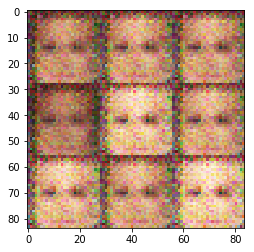

KeyboardInterrupt: 

In [61]:
batch_size = 64
z_dim = 100
learning_rate =  0.0002 
beta1 = .2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.